In [1]:
import os
import openai

In [2]:
import tiktoken

In [3]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

open.api_key = os.environ['OPENAI_API_KEY']

In [84]:
def complete_prompt(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0.6,
        max_tokens=60,
        stop=["."],
    )
    return response.choices[0].message.content

with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()
    complete_sentences = []
        
    for prompt in prompts: 
        generated_text = complete_prompt(prompt)
        complete_sentences.append(prompt + generated_text)
        print(f"No Cue Prompt:{prompt}")
        print(f"Generated Text:{generated_text}\n")

No Cue Prompt:The employees knew the contract 

Generated Text:inside and out, as they had spent hours reviewing it and discussing its terms with their legal team

No Cue Prompt:The mechanic accepted the car 

Generated Text:and began inspecting it for any issues

No Cue Prompt:The old man recalled the nurse

Generated Text: who had cared for him during his stay in the hospital

No Cue Prompt:The traveller heard the clock 

Generated Text:ticking in the distance, its steady rhythm echoing through the empty streets

No Cue Prompt:The worker maintained the walls 

Generated Text:by regularly inspecting for cracks or damage, patching up any holes or weak spots, and repainting or sealing as needed

No Cue Prompt:The apprentice forgot the bicycle 

Generated Text:at the store where he had borrowed it for a delivery

No Cue Prompt:The committee mentioned the issue 

Generated Text:of budget constraints during the meeting

No Cue Prompt:The army found the supplies 

Generated Text:hidden in a

In [85]:
cleaned_sentences = [sentence.replace('\n', '') for sentence in complete_sentences]
cleaned_sentences

['The employees knew the contract inside and out, as they had spent hours reviewing it and discussing its terms with their legal team',
 'The mechanic accepted the car and began inspecting it for any issues',
 'The old man recalled the nurse who had cared for him during his stay in the hospital',
 'The traveller heard the clock ticking in the distance, its steady rhythm echoing through the empty streets',
 'The worker maintained the walls by regularly inspecting for cracks or damage, patching up any holes or weak spots, and repainting or sealing as needed',
 'The apprentice forgot the bicycle at the store where he had borrowed it for a delivery',
 'The committee mentioned the issue of budget constraints during the meeting',
 'The army found the supplies hidden in a cave deep in the forest',
 'The umpire warned the spectators to refrain from making any derogatory remarks or comments towards the players on the field',
 'The coach discovered the player had a natural talent for the sport a

In [86]:
def categorize_sentences(messages,
                model="gpt-3.5-turbo",
                temperature=0,
                max_tokens=3000):
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return response.choices[0].message.content

In [87]:
sentences = ',\n'.join([
    f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
    for sentence in cleaned_sentences
])

system_message = """
You will be provided with a list of sentences.
For each sentence, classify whether it is a noun phrase (NP) or a sentential complement (S).
NP acts as the direct object of the main verb, while S acts as the embedded subject in an upcoming subordinate clause.
Provide the output in JSON format with the following structure:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

messages = [
    {'role': 'system', 'content': system_message}
]

response = categorize_sentences(messages)
with open("output.json", "w") as file:
    file.write(response)

In [88]:
print(response)

{
    "sentences": [
        {"sentence": "The employees knew the contract inside and out, as they had spent hours reviewing it and discussing its terms with their legal team", "is_NP": false, "is_S": true},
        {"sentence": "The mechanic accepted the car and began inspecting it for any issues", "is_NP": true, "is_S": false},
        {"sentence": "The old man recalled the nurse who had cared for him during his stay in the hospital", "is_NP": true, "is_S": false},
        {"sentence": "The traveller heard the clock ticking in the distance, its steady rhythm echoing through the empty streets", "is_NP": false, "is_S": true},
        {"sentence": "The worker maintained the walls by regularly inspecting for cracks or damage, patching up any holes or weak spots, and repainting or sealing as needed", "is_NP": true, "is_S": false},
        {"sentence": "The apprentice forgot the bicycle at the store where he had borrowed it for a delivery", "is_NP": true, "is_S": false},
        {"sentence

In [89]:
import json

with open("output.json") as chatGPT_sentences:    
    data = json.load(chatGPT_sentences)
    
    with open('np_chatGPT.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_chatGPT.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [17]:
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
import re

In [91]:
with open ("np_chatGPT.txt") as np_sentences, open ("s_chatGPT.txt") as s_sentences:
    np_sentences = np_sentences.read().lower()
    s_sentences = s_sentences.read().lower()
    
    np_tokens = nltk.word_tokenize(np_sentences)
    fdist_np = FreqDist(np_tokens)
    re_pattern = r'\w+'
    np_clean = []
    
    s_tokens = nltk.word_tokenize(s_sentences)
    fdist_s = FreqDist(s_tokens)
    re_pattern = r'\w+'
    s_clean = []
    
    for word in np_tokens:
        if re.match(re_pattern, word):
            np_clean.append(word)
            
    for word in s_tokens:
        if re.match(re_pattern, word):
            s_clean.append(word)

In [92]:
print(np_clean)

['the', 'mechanic', 'accepted', 'the', 'car', 'and', 'began', 'inspecting', 'it', 'for', 'any', 'issues', 'the', 'old', 'man', 'recalled', 'the', 'nurse', 'who', 'had', 'cared', 'for', 'him', 'during', 'his', 'stay', 'in', 'the', 'hospital', 'the', 'worker', 'maintained', 'the', 'walls', 'by', 'regularly', 'inspecting', 'for', 'cracks', 'or', 'damage', 'patching', 'up', 'any', 'holes', 'or', 'weak', 'spots', 'and', 'repainting', 'or', 'sealing', 'as', 'needed', 'the', 'apprentice', 'forgot', 'the', 'bicycle', 'at', 'the', 'store', 'where', 'he', 'had', 'borrowed', 'it', 'for', 'a', 'delivery', 'the', 'committee', 'mentioned', 'the', 'issue', 'of', 'budget', 'constraints', 'during', 'the', 'meeting', 'the', 'army', 'found', 'the', 'supplies', 'hidden', 'in', 'a', 'cave', 'deep', 'in', 'the', 'forest', 'the', 'umpire', 'warned', 'the', 'spectators', 'to', 'refrain', 'from', 'making', 'any', 'derogatory', 'remarks', 'or', 'comments', 'towards', 'the', 'players', 'on', 'the', 'field', 'the

In [93]:
print(len(np_clean))

440


In [94]:
print(s_clean)

['the', 'employees', 'knew', 'the', 'contract', 'inside', 'and', 'out', 'as', 'they', 'had', 'spent', 'hours', 'reviewing', 'it', 'and', 'discussing', 'its', 'terms', 'with', 'their', 'legal', 'team', 'the', 'traveller', 'heard', 'the', 'clock', 'ticking', 'in', 'the', 'distance', 'its', 'steady', 'rhythm', 'echoing', 'through', 'the', 'empty', 'streets', 'the', 'coach', 'discovered', 'the', 'player', 'had', 'a', 'natural', 'talent', 'for', 'the', 'sport', 'and', 'decided', 'to', 'give', 'them', 'more', 'playing', 'time', 'on', 'the', 'team', 'the', 'scientists', 'proved', 'the', 'theory', 'through', 'a', 'series', 'of', 'experiments', 'and', 'observations', 'that', 'provided', 'concrete', 'evidence', 'supporting', 'their', 'hypothesis', 'the', 'reporter', 'revealed', 'the', 'politician', 'had', 'been', 'involved', 'in', 'a', 'corruption', 'scandal', 'the', 'lawyer', 'established', 'the', 'alibi', 'for', 'his', 'client', 'by', 'presenting', 'evidence', 'that', 'showed', 'he', 'was', 'o

In [95]:
print(len(s_clean))

178


In [96]:
fdist_np = FreqDist(np_clean)
fdist_np.most_common(10)

[('the', 82),
 ('and', 12),
 ('to', 12),
 ('in', 8),
 ('of', 8),
 ('for', 6),
 ('from', 5),
 ('with', 5),
 ('had', 4),
 ('or', 4)]

In [97]:
fdist_s = FreqDist(s_clean)
fdist_s.most_common(10)

[('the', 29),
 ('and', 7),
 ('to', 4),
 ('as', 3),
 ('had', 3),
 ('its', 3),
 ('in', 3),
 ('through', 3),
 ('a', 3),
 ('of', 3)]

In [4]:
open.api_key = os.environ['ANTHROPIC_API_KEY']
import anthropic

In [11]:
import time

def complete_prompt_anthropic(prompt):
    message = anthropic.Anthropic().messages.create(
        model="claude-3-haiku-20240307",
        temperature=0.6,
        max_tokens=80,
        stop_sequences=["."],
        messages=[
            {"role": "user", 
             "content": f"Complete the following prompt into a full sentence: {prompt}"}
        ]
    )
    generated_text = message.content[0].text
    if ":" in generated_text:
        return generated_text[generated_text.index(":") + 1:].strip()
    else:
        return generated_text.strip()

with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()   
    complete_sentences_anthropic = []
    
    for prompt in prompts:
        complete_sentence = complete_prompt_anthropic(prompt.strip())
        complete_sentences_anthropic.append(complete_sentence)
        print(complete_sentence)
        time.sleep(15)

The employees knew the contract was about to expire
The mechanic accepted the car for repair
The old man recalled the nurse who had cared for him during his recent stay in the hospital
The traveller heard the clock strike midnight as they approached their destination
The worker maintained the walls by regularly cleaning, repairing, and painting them to keep them in good condition
The apprentice forgot the bicycle at the workshop
The committee mentioned the issue of climate change during their meeting
The army found the supplies hidden in the abandoned warehouse
The umpire warned the spectators to refrain from disruptive behavior and to respect the players and officials during the game
The coach discovered the player had been hiding an injury from the team
The woman noticed the flyer advertising a local community event
The tourists saw the palace in all its grandeur, its ornate architecture and intricate details captivating their attention
The scientists proved the theory to be accurate

In [12]:
with open('complete_sentences_anthropic.txt', 'w') as f:
    for line in complete_sentences_anthropic:
        f.write("%s\n" % line)

In [13]:
def categorize_anthropic_sentences():
    message = anthropic.Anthropic().messages.create(
        model="claude-3-haiku-20240307",
        temperature=0,
        max_tokens=3000,
        stop_sequences=["."],
        messages=[
            {"role": "user", 
             "content": system_message}
        ]
    )
    return message.content[0].text

with open ("complete_sentences_anthropic.txt") as sentences: 
    sentences = ',\n'.join([
        f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
        for sentence in sentences
    ])

system_message = """
You will be provided with a list of sentences.
For each sentence, classify whether it is a noun phrase (NP) or a sentential complement (S).
NP acts as the direct object of the main verb, while S acts as the embedded subject in an upcoming subordinate clause.
Provide the output in JSON format with the following structure:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

response = categorize_anthropic_sentences()
with open("anthropic_output.json", "w") as file:
    file.write(response)

In [15]:
import json

with open("anthropic_output.json") as anthropic_sentences:    
    data = json.load(anthropic_sentences)
    
    with open('np_anthropic.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_anthropic.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [23]:
with open ("np_anthropic.txt") as np_sentences, open ("s_anthropic.txt") as s_sentences:
    anth_np_sentences = np_sentences.read().lower()
    anth_s_sentences = s_sentences.read().lower()
    
    anth_np_tokens = nltk.word_tokenize(anth_np_sentences)
    fdist_np_anth = FreqDist(anth_np_tokens)
    re_pattern = r'\w+'
    anth_np_clean = []
    
    anth_s_tokens = nltk.word_tokenize(anth_s_sentences)
    fdist_s_anth = FreqDist(anth_s_tokens)
    re_pattern = r'\w+'
    anth_s_clean = []
    
    for word in anth_np_tokens:
        if re.match(re_pattern, word):
            anth_np_clean.append(word)
            
    for word in anth_s_tokens:
        if re.match(re_pattern, word):
            anth_s_clean.append(word)

In [24]:
print(len(anth_np_clean))

370


In [25]:
print(len(anth_s_clean))

130


In [26]:
fdist_np_anth.most_common(10)

[('the', 83),
 ('to', 14),
 ('in', 11),
 ('and', 11),
 (',', 5),
 ('with', 5),
 ('was', 4),
 ('for', 4),
 ('of', 4),
 ('their', 4)]

In [27]:
fdist_s_anth.most_common(10)

[('the', 28),
 ('to', 4),
 ('and', 4),
 ('they', 3),
 ('had', 3),
 ('of', 3),
 ('their', 2),
 ('from', 2),
 ('during', 2),
 ('be', 2)]

In [28]:
gpt_count_np = 0
gpt_count_s = 0

with open("np_chatGPT.txt") as chatGPT_np, open("s_chatGPT.txt") as chatGPT_s:
    for line in chatGPT_np:
        gpt_count_np += 1
    for line in chatGPT_s:
        gpt_count_s += 1

anth_count_np = 0
anth_count_s = 0

with open("np_anthropic.txt") as anthropic_np, open("s_anthropic.txt") as anthropic_s:
    for line in anthropic_np:
        anth_count_np += 1 
    for line in anthropic_s:
        anth_count_s += 1

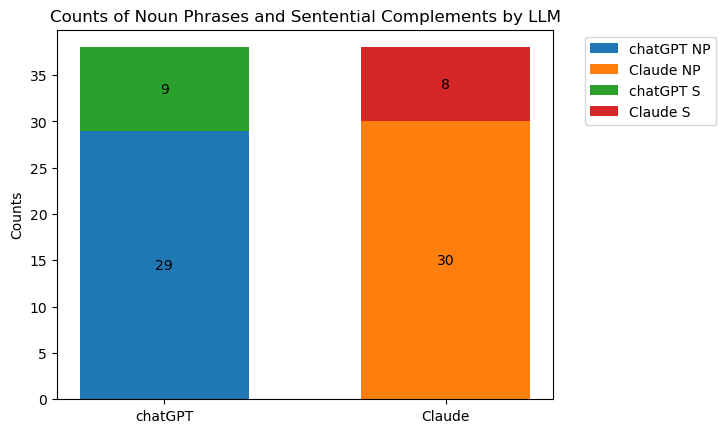

In [31]:
from matplotlib import pyplot as plt
import numpy as np

count_np = {
    'chatGPT': gpt_count_np,  
    'Claude': anth_count_np 
}
count_s = {
    'chatGPT': gpt_count_s,  
    'Claude': anth_count_s
}

LLMs = ['chatGPT', 'Claude']

width = 0.6
fig, ax = plt.subplots()

x = np.arange(len(LLMs))

bottom_np = np.zeros(len(LLMs))
bottom_s = np.zeros(len(LLMs))

for i, (LLM, count) in enumerate(count_np.items()):
    bars = ax.bar(x[i], count, width, label='{} NP'.format(LLM))
    bottom_np[i] += count
    ax.bar_label(bars, label_type='center')

for i, (LLM, count) in enumerate(count_s.items()):
    bars = ax.bar(x[i], count, width, label='{} S'.format(LLM), bottom=bottom_np[i])
    bottom_s[i] += count
    ax.bar_label(bars, label_type='center')

ax.set_ylabel('Counts')
ax.set_title('Counts of Noun Phrases and Sentential Complements by LLM')
ax.set_xticks(x)
ax.set_xticklabels(LLMs)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()